In [128]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
import seaborn as sns
%matplotlib inline

In [179]:
conn = sqlite3.connect("db\\otomoto.db")
df = pd.read_sql_query("select * from car_article;", conn)
# print(list(df))
print(df.info())
print('=' * 100)
print(df.describe(include=['object', 'bool']))
print('=' * 100)
print(df['year'].value_counts())
print('=' * 100)
print(df['year'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17573 entries, 0 to 17572
Data columns (total 18 columns):
id                 17573 non-null object
name               17573 non-null object
manufacturer       17573 non-null object
year               17573 non-null object
mileage            17573 non-null int64
engine_capacity    17573 non-null float64
engine_type        17573 non-null object
value              17573 non-null object
brutto             17573 non-null int64
netto              17573 non-null int64
negotiation        17573 non-null int64
vat                17573 non-null int64
currency           17573 non-null object
location           17573 non-null object
link               17573 non-null object
seller_id          17573 non-null object
record_created     17573 non-null object
on_delete          17573 non-null int64
dtypes: float64(1), int64(6), object(11)
memory usage: 1.7+ MB
None
                                      id        name manufacturer        year  \
count    

In [182]:
import datetime
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
reg = LinearRegression()

# fit transforme could be replaced by fit_transform() method


# transforme dates to labels
years = pd.to_datetime(df['year'], format='%Y-%m-%d')
years = years.apply(lambda x: x.year)
#encode years to classes
le.fit(years)
df['year'] = le.transform(years)

# filter articles
df = df[df['engine_capacity'] > 0.5]
df = df[df['currency'] == 'pln']

# care prices to float
df['value'] = df['value'].astype('float')
labels = df['value']

# encode names to classes
le.fit(df['name'])
df['name'] = le.transform(df['name']) 

# encode manufacturer to classes
le.fit(df['manufacturer'])
df['manufacturer'] = le.transform(df['manufacturer']) 

# encode location to classes
le.fit(df['location'])
df['location'] = le.transform(df['location'])

# drop unrelevant data
df = df.drop(['id', 'vat', 'netto', 'brutto', 'negotiation', 'engine_type', 'currency', 'link', 'seller_id', 'record_created', 'on_delete', 'location', 'mileage'], axis=1)

# create traine set
train1 = df.drop(['value'], axis=1)

In [195]:
# df[df['value'] > 100000]
# df['value'].max()

# df.groupby(df['value']).max()

# val_max = df['value'].max()

# %timeit df['value'] = df[(0 <= df['value']) & (df['value'] <= val_max)]['value']
# %timeit df = df.query('{} <= value <= {}'.format(0, 799999))

UnboundLocalError: local variable 'df' referenced before assignment

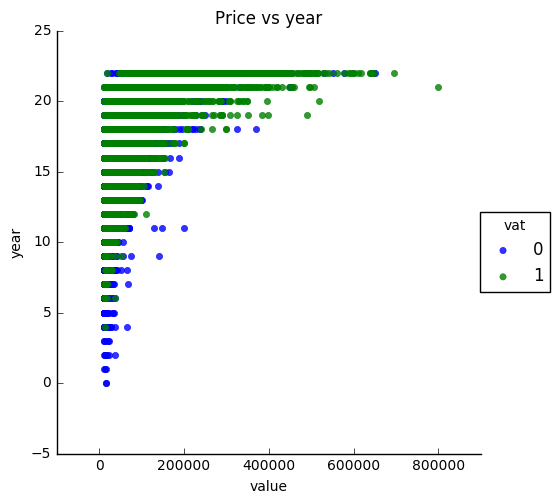

In [159]:
# plt.scatter(df['value'], df['year'])
# df.loc[:, ['value', 'year']]
sns.lmplot(x='value', y='year', data=df, fit_reg=False, hue='vat')
plt.title('Price vs year')
sns.despine()
plt.show()

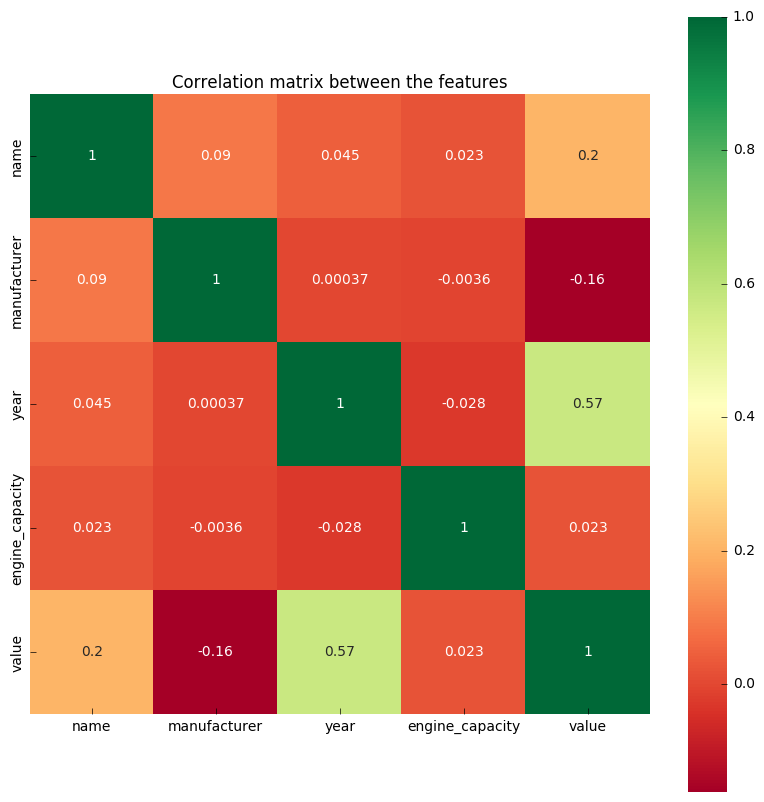

In [162]:
correlation_matrix = df.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True, cmap='RdYlGn')
plt.title('Correlation matrix between the features')
plt.show()

In [ ]:
# from sklearn.feature_selection import RFE

# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression()

# rfe = RFE(model, 3)

# fit = rfe.fit(train1, labels)

# print("Num Features: %d") % fit.n_features_

# print("Selected Features: %s") % fit.support_

# print("Feature Ranking: %s") % fit.ranking_

In [163]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train1, labels, test_size=0.1, random_state=2)

reg.fit(x_train, y_train)
score = reg.score(x_test, y_test) 
accuracy = int(reg.score(x_test, y_test) * 100) 
print('score: {}\naccurancy: {} %'.format(score, accuracy))

from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 155, max_depth = 4, min_samples_split = 2, learning_rate = 0.4, loss = 'ls') 
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test) 
accuracy = int(clf.score(x_test, y_test) * 100) 
print('score: {}\naccurancy: {} %'.format(score, accuracy))

score: 0.37627286952122263
accurancy: 37 %
score: 0.9238617594128897
accurancy: 92 %


In [165]:
r = clf.predict([[397, 30, 16, 1.6]])
print('Predicted value: ',r[0])
# print('Real value: ', df.iloc[5].value)
# print(df.iloc[5])
test_slice = df[df['name'] == 397].groupby('year')
print(test_slice.value.agg(['min', 'max', 'mean']))
print(test_slice.value.quantile([0.5]))
print(df[(df['name'] == 397) & (df['year'] == 16)])

Predicted value:  19850.4056043
          min      max          mean
year                                
13    12800.0  20900.0  16850.000000
14    17600.0  22000.0  19580.000000
15    25900.0  28900.0  27266.666667
16    12400.0  29900.0  20147.857143
17    10500.0  38500.0  22519.076923
18    13400.0  41400.0  24225.928571
19    15500.0  41900.0  28341.666667
20    16500.0  43900.0  27480.000000
21    19800.0  50500.0  42025.000000
22    53900.0  72700.0  63953.333333
year     
13    0.5    16850.0
14    0.5    19500.0
15    0.5    27000.0
16    0.5    19800.0
17    0.5    20900.0
18    0.5    23791.0
19    0.5    29200.0
20    0.5    26900.0
21    0.5    48900.0
22    0.5    64350.0
dtype: float64
       name  manufacturer  year  engine_capacity    value
124     397            30    16              1.6  12400.0
150     397            30    16              1.6  12700.0
549     397            30    16              1.6  15447.0
719     397            30    16              1.6  17900.0

ValueError: Found input variables with inconsistent numbers of samples: [16711, 1]